In [1]:
import sys
sys.path.append('/app/')  # noqa
sys.path.append('/app/loopa')  # noqa

from jina import Document, DocumentArray, Flow, Executor, requests
from jina.types.request import Request
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import argparse
from loopa.executors.index import IndexMerger
from loopa.executors.bert import SBERTEncoder
from memlish.executors.index import FaissIndexer
from memlish.config import MONGO_EMBEDDING_DB_NAME, JINA_SBERT_EMBEDDING_TEMPLATE_TEXT_COLLECTION, IMGFLIP_DIR
from loopa.config import CUDA_IF_AVAILABLE
import torch
import hashlib

def my_hash(s): 
    return str(int(hashlib.md5(str(s).encode('utf-8')).hexdigest(), 16))

In [2]:
def plot_search_results(resp: Request):
    for doc in resp.docs:
        print(f'Query text: {doc.text}')
        print(f'Matches:')
        print('-'*10)
        show_docs(doc.matches)
        
def show_docs(docs):
    for doc in docs:
        doc.load_uri_to_image_blob()
        plt.imshow(doc.blob)
        plt.show()

In [3]:
torch.multiprocessing.set_start_method('fork', force=True) 

In [4]:
embedder_params = {
    "device": "cpu"
}

faiss_indexer_params = {
    "reference_img_dir":str(IMGFLIP_DIR),
    "db_name": MONGO_EMBEDDING_DB_NAME,
    "collection_name": JINA_SBERT_EMBEDDING_TEMPLATE_TEXT_COLLECTION,
}

In [5]:
flow_search = Flow().add(uses=SBERTEncoder, name="encoder", uses_with=embedder_params) \
                    .add(uses=FaissIndexer,name="indexer",workspace="workspace", uses_with=faiss_indexer_params)
flow_search

⠼ 2/3 waiting indexer to be ready...                                              Index intitialized successfully!
           Flow@3381[I]:🎉 Flow is ready to use!                                           
	🔗 Protocol: 		GRPC
	🏠 Local access:	0.0.0.0:59189
	🔒 Private network:	172.20.0.5:59189
	🌐 Public address:	35.224.116.253:59189
⠹ Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 0:00:03 estimating... end - start 3.229787588119507
⠸ Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 0:00:03 estimating... Query text: HEllo mother fucker!
Matches:
----------
⠴ Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 0:00:03 estimating... 

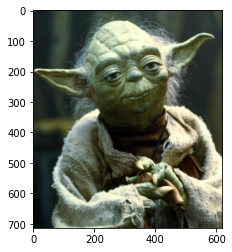

⠦ Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 0:00:03 estimating... 

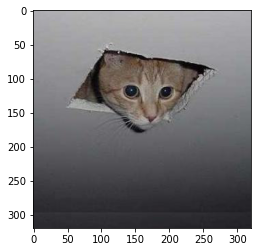

⠇ Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 0:00:03 estimating... 

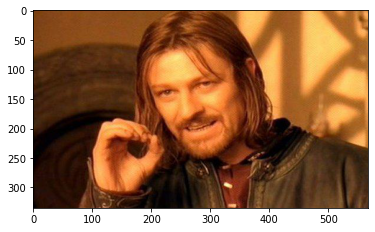

⠋ Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 0:00:04 estimating... 

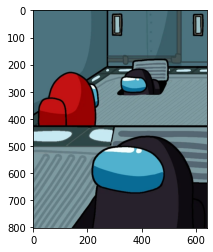

⠙ Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 0:00:04 estimating... 

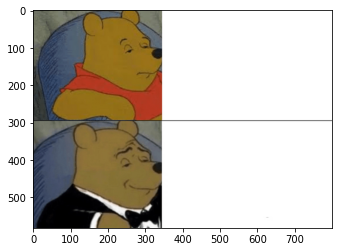

⠹       DONE ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 0:00:04 100% ETA: 0 seconds 80 steps done in 4 seconds


In [6]:
with flow_search:
    resp = flow_search.post(on='/search',inputs=DocumentArray([
                    Document(text='HEllo mother fucker!')
                ]), parameters={"top_k":5}, on_done=plot_search_results, show_progress=True, return_results=False)